## WOESC Demo 

### Code by: Stephen Denton, Scotiabank

This notebook demonstrates how you can generate and plot weight of evidence (WOE) values in python and create a simple WOE Logistic Regression model.

#### This only works on the py37-conda kernel, because other kernels do not have the mlxtend package and have older versions of scikit-learn that do not include the no regularization penalty version of logistic regression.

In [1]:
import sys
sys.path.append('..')

## Import WOESC library (which will import a number of other libraries: pandas, numpy, dask...)
from woesc_utils import *
from data_utils import *

from scipy.stats import ks_2samp

from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import ipywidgets as ipw

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = [8, 4]

print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("scipy version:", sys.modules['scipy'].__version__)
print("matplotlib version:", sys.modules['matplotlib'].__version__)
print("scikit-learn version:", sys.modules['sklearn'].__version__)
print("mlxtend version:", sys.modules['mlxtend'].__version__)
print("dask version:", dask.__version__)

numpy version: 1.20.1
pandas version: 1.1.5
scipy version: 1.5.3
matplotlib version: 3.3.4
scikit-learn version: 0.23.1
mlxtend version: 0.18.0
dask version: 2021.02.0


## Import some data

Dataset should include a binary target variable that indicates if the behavior we are interested in predicting occurred *after* the rest of the data was collected.

The below data set has a **loan_default** variable that will be the target for the model.

In [2]:
## Import training data from kaggle: https://www.kaggle.com/sneharshinde/ltfs-av-data
#dat = pd.read_feather('train.fth')
dat = pd.read_csv('train.csv')


## Get some basic information about the dataset
print("Shape of the dataset (rows, columns):", dat.shape, "\n")
dat.info()

Shape of the dataset (rows, columns): (233154, 41) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate              

In [3]:
## Show the first n records in the dataset
dat.head(8)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,Self employed,19-09-18,6,1998,1,1,0,0,0,0,825,A-Very Low Risk,2,0,0,0,0,0,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,Salaried,23-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,Salaried,16-09-18,6,1998,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0


In [4]:
## Specify special columns in the dataset that are identification or target variables
## You can have multiple id_vars, hence it is required to be a list 
id_vars = ['UniqueID']
targ_var = 'loan_default'

In [5]:
# Perform some (optional) feature engineering and dataset clean-up
dat = preprocess_vehicle_data(dat, id_vars, targ_var)

In [6]:
## Get summary of data target using convenience function 'describe_data_g_targ'
## Note: The 'Null' model predicts the base rate for all training data - in ML called a Dummy Classifier Baseline
datdict = describe_data_g_targ(dat, targ_var) # , logbase=2);

Number of records (num): 233154
Target count (n_targ): 50611
Target rate (base_rate): 0.2170711203753742
Target odds (base_odds): 0.2772552220572687
Target log odds (base_log_odds): -1.2828168177360064
Dummy model negative log-likelihood (NLL_null): 121980.55416139046
Dummy model LogLoss (LogLoss_null): 0.5231759015989023



In [7]:
#valsets = ['val001']
#trndat = dat.loc[~dat[valsets[0]], :]
#valdat = dat.loc[dat[valsets[0]], :]
#trndat.shape, valdat.shape

trndat, valdat = model_selection.train_test_split(dat, test_size=0.5, random_state=0, stratify=dat[[targ_var]])
print(trndat.shape)
trndat.sort_index().head()

(116577, 36)


,UniqueID,loan_default,disbursed_amount,asset_cost,ltv,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERF_CNS_SC_DESC,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_LAST_6_MTHS,DELI_ACCTS_LAST_6_MTHS,NO_OF_INQUIRIES,AgeInMonths,DaysSinceDisbursement,AcctAgeInMonths,CreditHistLenInMonths
0,417428,0,55013,64080,88.17,86,Self employed,4,1,0,0,0,0,681.0,E-Low Risk,9.0,3.0,0.0,63727.0,100984.0,100984.0,0,0,0,0,0,0,5571.0,0,1,0,0,638.0,153.0,9,12
3,417431,0,53503,76245,72.14,86,Self employed,3,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,384.0,153.0,0,0
5,417433,0,42494,60086,74.89,86,Salaried,10,1,0,0,0,0,673.0,F-Low Risk,8.0,2.0,0.0,120985.0,130600.0,130600.0,0,0,0,0,0,0,15820.0,0,1,0,0,346.0,153.0,10,19
6,417434,0,45879,68318,70.99,86,Self employed,13,0,1,1,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,287.0,153.0,0,0
7,417435,0,71393,98533,73.65,48,Self employed,6,1,0,0,0,0,NaN,Not Scored: No Activity seen on the customer (...,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,428.0,153.0,6,6


In [8]:
## Attach a validation set indicator to the original dataset
valsets = ['val001']
if valsets[0] not in dat.columns:
    dat.insert(0, valsets[0], False)
    dat.loc[valdat.index, valsets[0]] = True

print(dat.shape, dat[valsets[0]].sum())
dat.head()

(233154, 37) 116577


,val001,UniqueID,loan_default,disbursed_amount,asset_cost,ltv,manufacturer_id,Employment_Type,State_ID,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS_SCORE,PERF_CNS_SC_DESC,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,SEC_NO_OF_ACCTS,SEC_ACTIVE_ACCTS,SEC_OVERDUE_ACCTS,SEC_CURRENT_BALANCE,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_LAST_6_MTHS,DELI_ACCTS_LAST_6_MTHS,NO_OF_INQUIRIES,AgeInMonths,DaysSinceDisbursement,AcctAgeInMonths,CreditHistLenInMonths
0,False,417428,0,55013,64080,88.17,86,Self employed,4,1,0,0,0,0,681.0,E-Low Risk,9.0,3.0,0.0,63727.0,100984.0,100984.0,0,0,0,0,0,0,5571.0,0,1,0,0,638.0,153.0,9,12
1,True,417429,0,72567,88919,83.78,86,Salaried,8,1,1,0,0,0,384.0,K-High Risk,3.0,1.0,1.0,103435.0,100000.0,100000.0,0,0,0,0,0,0,160963.0,0,0,1,0,478.0,153.0,36,42
2,True,417430,0,49049,64217,77.39,86,Self employed,6,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,441.0,153.0,0,0
3,False,417431,0,53503,76245,72.14,86,Self employed,3,1,0,0,0,0,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,NaN,0,0,0,0,384.0,153.0,0,0
4,True,417432,0,55559,65524,85.92,86,Self employed,6,1,0,0,0,0,721.0,D-Very Low Risk,8.0,7.0,0.0,1692406.0,2098401.0,2066815.0,0,0,0,0,0,0,15028.0,0,3,2,0,343.0,153.0,15,35


In [9]:
## Get summary of target for training dataset
trndict = describe_data_g_targ(trndat, targ_var)

Number of records (num): 116577
Target count (n_targ): 25306
Target rate (base_rate): 0.217075409386071
Target odds (base_odds): 0.27726221910574006
Target log odds (base_log_odds): -1.2827915812043762
Dummy model negative log-likelihood (NLL_null): 60990.918482794936
Dummy model LogLoss (LogLoss_null): 0.5231814035598354



In [10]:
## Set a minimum bin size control parameter
## Common practice is to set the minimum bin size to be 2% of the data
MIN_BIN_SIZE = int(np.ceil(trndat.shape[0] * .02))
MIN_BIN_SIZE

2332

## Perform some Exploratory Data Analysis (EDA)

Use the univariate scorecard plot function to look at the marginal/main effect of particular variables cut into particular numbers of bins.  The function `unvariate_sc_plot` takes a dataset, a predictor variable, the target variable, and a **n_cuts** value that will determine the number of bins the predictor variable is split into.

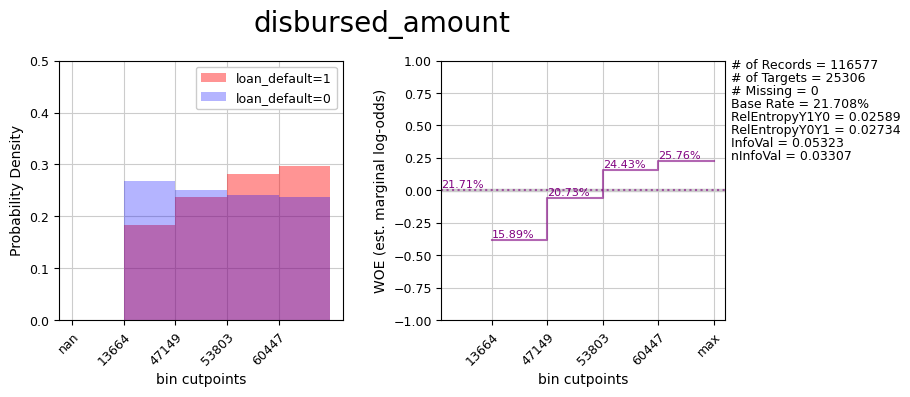

bin  bin_ct  \
var_name         binner req_cuts bins bin_idx                               
disbursed_amount qntl   4        5    0                         .       0   
                                      1        [13664.0, 47149.0)   29137   
                                      2        [47149.0, 53803.0)   28985   
                                      3        [53803.0, 60447.0)   29242   
                                      4            [60447.0, inf)   29213   

                                               bin_min       ranks    Y1  \
var_name         binner req_cuts bins bin_idx                              
disbursed_amount qntl   4        5    0            NaN           0     0   
                                      1        13664.0  (1.0, 1.0)  4629   
                                      2        47149.0  (2.0, 2.0)  6009   
                                      3        53803.0  (3.0, 3.0)  7143   
                                      4        60447.0  (4.0, 4.0)  7525   

                                                  Y0   bin_pct  targ_rate  \
var_name         binner req_cuts bins bin_idx                               
disbursed_amount qntl   4        5    0            0  0.000000   0.000000   
                                      1        24508  0.249938   0.158870   
                                      2        22976  0.248634   0.207314   
                                      3        22099  0.250839   0.244272   
                                      4        21688  0.250590   0.257591   

                                                 p_XgY1    p_XgY0       WOE  \
var_name         binner req_cuts bins bin_idx                                 
disbursed_amount qntl   4        5    0        0.000040  0.000040  0.000000   
                                      1        0.182924  0.268505 -0.383798   
                                      2        0.237446  0.251724 -0.058391   
                                      3        0.282249  0.242117  0.153369   
                                      4        0.297341  0.237615  0.224230   

                                                 KLY1Y0    KLY0Y1        IV  \
var_name         binner req_cuts bins bin_idx                                 
disbursed_amount qntl   4        5    0        0.000000 -0.000000  0.000000   
                                      1       -0.070206  0.103052  0.032846   
                                      2       -0.013865  0.014698  0.000834   
                                      3        0.043288 -0.037133  0.006155   
                                      4        0.066673 -0.053280  0.013392   

                                                    nIV  bin_pred  
var_name         binner req_cuts bins bin_idx                      
disbursed_amount qntl   4        5    0        0.000000  0.217075  
                                      1        0.020408  0.158879  
                                      2        0.000518  0.207316  
                                      3        0.003824  0.244268  
                                      4        0.008321  0.257584

In [11]:
## Create a univariate scorecard plot for the first (continuous) variable in the dataset
univariate_sc_plot( trndat, 'disbursed_amount', targ_var, n_cuts=4)

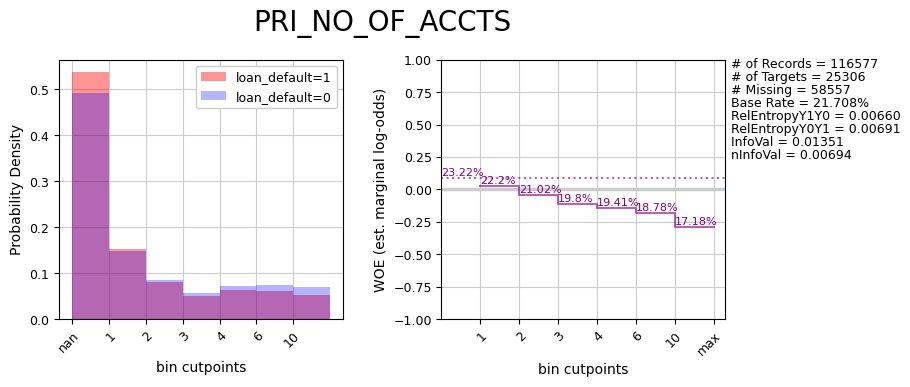

In [12]:
## Univariate scorecard of a count variable that include missing values
univariate_sc_plot( trndat, 'PRI_NO_OF_ACCTS', targ_var, n_cuts=8);

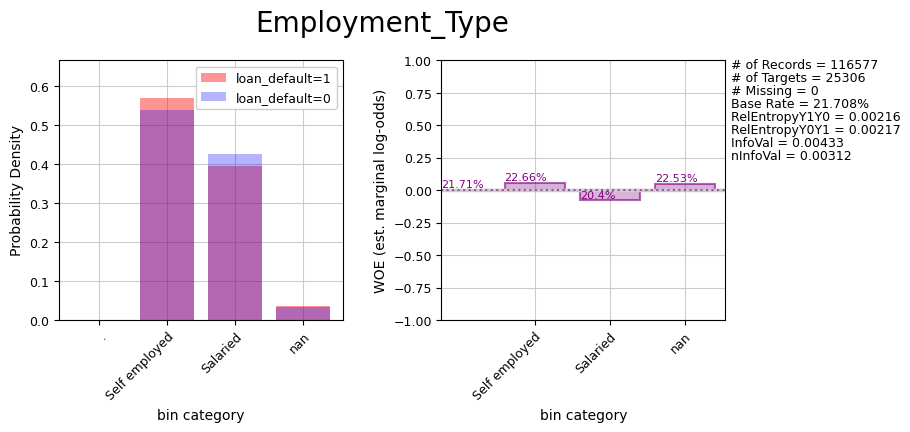

In [13]:
## Univariate scorecard of a categorical/nominal variable 
univariate_sc_plot( trndat, 'Employment_Type', targ_var, n_cuts=5 );

## Generate a model space of univariate scorecards 

The **create_woesc_df** function creates multiple univariate scorecards as the cross/outer product of specified options (predictor variables, # of cuts, binners, etc.)

There are currently 3 binners implemented in the woesc package.  
- 'qntl' : a quantile/rank binner (the default shown above)
- 'gini' : a tree-based binner that uses Gini impurity criterion for recursive partitioning
- 'entropy' : a tree-based binner that uses information gain criterion for judging split quality

In [14]:
## Create a bunch of univariate scorecard models to evaluate and chose from

inc_p_vars = sorted(trndat.columns.drop(id_vars+[targ_var]))  ## Include all variables except id and target vars.
inc_n_cuts = [2, 3, 4, 5, 6, 8]  ## Cut all variables into different numbers of bins
inc_bnrs = ['qntl', 'gini', 'entropy']

woesc_df = create_woesc_df(inc_p_vars, inc_n_cuts, inc_bnrs, trndat, targ_var
                            , min_bin_size=MIN_BIN_SIZE, neutralizeMissing=True)
print(woesc_df.shape)

(1734, 15)


In [15]:
display(woesc_df.head(8))
# display(woesc_df.tail(12))

bin  bin_ct bin_min  \
var_name        binner  req_cuts bins bin_idx                               
Aadhar_flag     none    2        3    0                 .       0      {}   
                                      1                 1   97946     {1}   
                                      2                 0   18631     {0}   
AcctAgeInMonths entropy 2        3    0                 .       0     NaN   
                                      1        [0.0, 1.5)   60952       0   
                                      2        [1.5, inf)   55625     1.5   
                        3        4    0                 .       0     NaN   
                                      1        [0.0, 1.5)   60952       0   

                                                    ranks     Y1     Y0  \
var_name        binner  req_cuts bins bin_idx                             
Aadhar_flag     none    2        3    0                 0      0      0   
                                      1                 1  20596  77350   
                                      2                 2   4710  13921   
AcctAgeInMonths entropy 2        3    0                 0      0      0   
                                      1        (1.0, 1.0)  14186  46766   
                                      2        (2.0, 2.0)  11120  44505   
                        3        4    0                 0      0      0   
                                      1        (1.0, 1.0)  14186  46766   

                                                bin_pct  targ_rate    p_XgY1  \
var_name        binner  req_cuts bins bin_idx                                  
Aadhar_flag     none    2        3    0        0.000000   0.000000  0.000040   
                                      1        0.840183   0.210279  0.813821   
                                      2        0.159817   0.252804  0.186139   
AcctAgeInMonths entropy 2        3    0        0.000000   0.000000  0.000040   
                                      1        0.522848   0.232741  0.560552   
                                      2        0.477152   0.199910  0.439409   
                        3        4    0        0.000000   0.000000  0.000040   
                                      1        0.522848   0.232741  0.560529   

                                                 p_XgY0       WOE    KLY1Y0  \
var_name        binner  req_cuts bins bin_idx                                 
Aadhar_flag     none    2        3    0        0.000040  0.000000  0.000000   
                                      1        0.847415 -0.040450 -0.032919   
                                      2        0.152545  0.199034  0.037048   
AcctAgeInMonths entropy 2        3    0        0.000040  0.000000  0.000000   
                                      1        0.512365  0.089884  0.050385   
                                      2        0.487596 -0.104056 -0.045723   
                        3        4    0        0.000040  0.000000  0.000000   
                                      1        0.512345  0.089884  0.050383   

                                                 KLY0Y1        IV  bin_pred  
var_name        binner  req_cuts bins bin_idx                                
Aadhar_flag     none    2        3    0       -0.000000  0.000000  0.217075  
                                      1        0.034278  0.001359  0.210279  
                                      2       -0.030362  0.006686  0.252796  
AcctAgeInMonths entropy 2        3    0       -0.000000  0.000000  0.217075  
                                      1       -0.046053  0.004331  0.232739  
                                      2        0.050737  0.005014  0.199912  
                        3        4    0       -0.000000  0.000000  0.217075  
                                      1       -0.046052  0.004331  0.232739

In [16]:
## Drop some univariate scorecards that we don't like, so they won't be considered further

p_vars = ['DaysSinceDisbursement', 'PRI_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT']
bnrs = [ 'gini', 'entropy']
cuts = [8]

for p_var in p_vars:
    for bnr in bnrs:
        for cut in cuts:
            try: woesc_df.drop(index=(p_var, bnr, cut), inplace=True)
            except: None

In [18]:
## Manually add a WOE dataframe to the model set
## Note the min_bin_size is lower for this added variable
addition_woe_df = gen_woe_df( trndat, 'PERF_CNS_SC_DESC', targ_var, n_cuts=0, laplace=1
                             , min_bin_size=500, compute_stats=True )
woesc_df = woesc_df.append(addition_woe_df, sort=False).sort_index()
woesc_df = woesc_df.loc[~woesc_df.index.duplicated(keep='last'),:]
woesc_df.loc['PERF_CNS_SC_DESC', 'none', :]

bin  \
var_name         binner req_cuts bins bin_idx                                                      
PERF_CNS_SC_DESC none   0        19   0                                                        .   
                                      1                                          C-Very Low Risk   
                                      2                                          A-Very Low Risk   
                                      3                                          D-Very Low Risk   
                                      4                                          B-Very Low Risk   
                                      5                                         M-Very High Risk   
                                      6                                               F-Low Risk   
                                      7                                              K-High Risk   
                                      8                                            H-Medium Risk   
                                      9                                               E-Low Risk   
                                      10                                           I-Medium Risk   
                                      11                                              G-Low Risk   
                                      12            Not Scored: Sufficient History Not Available   
                                      13       Not Scored: Not Enough Info available on the c...   
                                      14                                             J-High Risk   
                                      15       Not Scored: No Activity seen on the customer (...   
                                      16       Not Scored: No Updates available in last 36 mo...   
                                      17                                        L-Very High Risk   
                                      18                                                   Other   

                                               bin_ct  \
var_name         binner req_cuts bins bin_idx           
PERF_CNS_SC_DESC none   0        19   0         58557   
                                      1          8033   
                                      2          7091   
                                      3          5668   
                                      4          4627   
                                      5          4377   
                                      6          4202   
                                      7          4132   
                                      8          3480   
                                      9          2875   
                                      10         2686   
                                      11         1951   
                                      12         1893   
                                      13         1875   
                                      14         1869   
                                      15         1429   
                                      16          761   
                                      17          592   
                                      18          479   

                                                                                         bin_min  \
var_name         binner req_cuts bins bin_idx                                                      
PERF_CNS_SC_DESC none   0        19   0                                                       {}   
                                      1                                        {C-Very Low Risk}   
                                      2                                        {A-Very Low Risk}   
                                      3                                        {D-Very Low Risk}   
                                      4                                        {B-Very Low Risk}   
                                      5                                       {M-Very High Ris

## Evaluate all the univariate models just generated

The **gen_uscm_df** function calculates the Information Value (IV) for each univariate scorecard in the model space and determines if the univariate scorecard is monotonic.

In [19]:
## Create univariate scorecard metrics dataFrame 
uscm_df = gen_uscm_df(woesc_df)
print(uscm_df.shape)
# uscm_df.head(12)

(326, 7)


In [20]:
## Specify which variables are required to have a monotonic relationship with the outcome variable
monotonic_vars = ['CreditHistLenInMonths', 'PERFORM_CNS_SCORE', 'AgeInMonths', 'ltv']
monotonic_constraints = pd.Series(False, index=inc_p_vars)
monotonic_constraints[monotonic_vars] = True
monotonic_constraints[monotonic_constraints]

AgeInMonths              True
CreditHistLenInMonths    True
PERFORM_CNS_SCORE        True
ltv                      True
dtype: bool

In [21]:
## Remove non-monotonic versions of variables that are required to be monotonic from uscm_df
mc = monotonic_constraints[monotonic_constraints].index
# display(uscm_df.loc[mc])
mono_rows = uscm_df.loc[mc][uscm_df.loc[mc, 'monotonic']]
nonmono_rows = uscm_df.loc[mc][~uscm_df.loc[mc, 'monotonic'].astype(bool)] 
uscm_df.drop(index=nonmono_rows.index, inplace=True)
# uscm_df.loc[mc]

In [22]:
## Sort unvariate model metrics dataframe by Information Value (IV) and look at the most informative 
uscm_df.sort_values('IV', ascending=False, inplace=True)
# uscm_df.head(12)

In [23]:
## Apply a Information Value (IV) criterion for model inclusion
IV_threshold = .01

inc_p_vars = uscm_df[uscm_df.IV >= IV_threshold].index.get_level_values('var_name').unique().tolist()
print("Number of WOE variables considered:", len(inc_p_vars))
inc_p_vars

Number of WOE variables considered: 17


['ltv',
 'disbursed_amount',
 'PERF_CNS_SC_DESC',
 'PERFORM_CNS_SCORE',
 'State_ID',
 'PRI_OVERDUE_ACCTS',
 'DaysSinceDisbursement',
 'PRI_SANCTIONED_AMOUNT',
 'PRI_DISBURSED_AMOUNT',
 'PRI_CURRENT_BALANCE',
 'CreditHistLenInMonths',
 'PRIMARY_INSTAL_AMT',
 'PRI_ACTIVE_ACCTS',
 'AgeInMonths',
 'AcctAgeInMonths',
 'manufacturer_id',
 'PRI_NO_OF_ACCTS']

In [24]:
## Perform WOE transformation on the chosen variables 
inclusion_crit = 'IV'
uscm_df.sort_values(inclusion_crit, ascending=False, inplace=True)

woe_dat = dat[valsets + id_vars + [targ_var]].copy()

scorecards_df = pd.DataFrame()
inc_var_uscm = pd.DataFrame()
for p_var in inc_p_vars:
    var_uscm = uscm_df.loc[[p_var]]
    if monotonic_constraints[p_var]:
        var_uscm = var_uscm[var_uscm.monotonic]
    inc_var_uscm = pd.concat([inc_var_uscm, var_uscm.iloc[[0],:]])
    best_params = var_uscm.reset_index().iloc[[0], :4]
    #display(best_params)
    
    rdat = dat[[id_vars[0], targ_var, p_var]].copy()
    
    WOE_df = woesc_df.loc(axis=0)[p_var, best_params.binner, best_params.req_cuts, :]
    scorecards_df = pd.concat([scorecards_df,  WOE_df])
    
    wdat = woe_score_var( rdat, WOE_df, False )
    
    woe_dat = pd.concat([woe_dat, wdat['WOE_'+p_var]], axis=1)   

print("\nWOE transformed data shape (rows, columns):", woe_dat.shape, "\n")

PERF_CNS_SC_DESC - Creating 'Other' category from: ['Not Scored: More than 50 active Accounts found'
 'Not Scored: Only a Guarantor']
State_ID - Creating 'Other' category from: ['10' '11' '12' '15' '16' '17' '18' '19' '2' '20' '21' '22' '6' '7' '9']
manufacturer_id - Creating 'Other' category from: ['145' '152' '153' '156' '51' '67']

WOE transformed data shape (rows, columns): (233154, 20) 



In [25]:
## Look at the first 8 records of the WOE transformed data set.
woe_dat.head(8)

,val001,UniqueID,loan_default,WOE_ltv,WOE_disbursed_amount,WOE_PERF_CNS_SC_DESC,WOE_PERFORM_CNS_SCORE,WOE_State_ID,WOE_PRI_OVERDUE_ACCTS,WOE_DaysSinceDisbursement,WOE_PRI_SANCTIONED_AMOUNT,WOE_PRI_DISBURSED_AMOUNT,WOE_PRI_CURRENT_BALANCE,WOE_CreditHistLenInMonths,WOE_PRIMARY_INSTAL_AMT,WOE_PRI_ACTIVE_ACCTS,WOE_AgeInMonths,WOE_AcctAgeInMonths,WOE_manufacturer_id,WOE_PRI_NO_OF_ACCTS
0,False,417428,0,0.231494,0.070907,-0.294327,-0.235473,-0.073447,-0.217797,0.137416,-0.003795,-0.036161,0.202109,-0.042313,-0.027208,-0.127772,-0.081339,-0.202685,-0.071636,-0.167119
1,True,417429,0,0.231494,0.273028,0.280940,0.310502,0.080721,0.255228,0.137416,-0.003795,-0.036161,-0.045988,-0.188994,-0.399694,0.007865,-0.081339,-0.113901,-0.071636,-0.115879
2,True,417430,0,0.020337,-0.108194,0.086861,0.000000,-0.018820,0.000000,0.137416,0.000000,0.000000,0.000000,0.089692,0.000000,0.000000,-0.081339,0.089884,-0.071636,0.000000
3,False,417431,0,-0.167274,0.070907,0.086861,0.000000,-0.200522,0.000000,0.137416,0.000000,0.000000,0.000000,0.089692,0.000000,0.000000,0.022773,0.089884,-0.071636,0.000000
4,True,417432,0,0.231494,0.190333,-0.472548,-0.235473,-0.018820,-0.217797,0.137416,-0.623023,-0.611989,-0.560300,-0.042313,-0.027208,-0.476620,0.022773,-0.038904,-0.071636,-0.167119
5,False,417433,0,0.020337,-0.360175,-0.190957,-0.235473,-0.018820,-0.217797,0.137416,-0.003795,-0.036161,-0.045988,-0.042313,-0.027208,-0.058608,0.022773,-0.099258,-0.071636,-0.167119
6,False,417434,0,-0.167274,-0.228714,0.086861,0.000000,0.468796,0.000000,0.137416,0.000000,0.000000,0.000000,0.089692,0.000000,0.000000,0.174380,0.089884,-0.071636,0.000000
7,False,417435,0,0.020337,0.273028,-0.233788,0.000000,-0.018820,-0.217797,0.137416,-0.078774,-0.097075,-0.094157,-0.042313,-0.206039,-0.110064,-0.081339,-0.115284,0.292521,0.028583


In [26]:
## Split the WOE transformed variables back into training and validation sets
trn_woe_dat = woe_dat[~woe_dat[valsets[0]]]
val_woe_dat = woe_dat[woe_dat[valsets[0]]]
print(trn_woe_dat.shape, val_woe_dat.shape)

(116577, 20) (116577, 20)


In [27]:
## Get a list of the WOE variables in the WOE transformed dataset
WOE_vars = trn_woe_dat.columns[trn_woe_dat.columns.str.startswith("WOE_")].tolist()
WOE_vars

['WOE_ltv',
 'WOE_disbursed_amount',
 'WOE_PERF_CNS_SC_DESC',
 'WOE_PERFORM_CNS_SCORE',
 'WOE_State_ID',
 'WOE_PRI_OVERDUE_ACCTS',
 'WOE_DaysSinceDisbursement',
 'WOE_PRI_SANCTIONED_AMOUNT',
 'WOE_PRI_DISBURSED_AMOUNT',
 'WOE_PRI_CURRENT_BALANCE',
 'WOE_CreditHistLenInMonths',
 'WOE_PRIMARY_INSTAL_AMT',
 'WOE_PRI_ACTIVE_ACCTS',
 'WOE_AgeInMonths',
 'WOE_AcctAgeInMonths',
 'WOE_manufacturer_id',
 'WOE_PRI_NO_OF_ACCTS']

In [28]:
## Calculate Spearman correlation among WOE transformed variables
corr_mat = trn_woe_dat.loc[:, WOE_vars].corr(method='spearman')
# corr_mat

In [29]:
## Apply a threshold on Spearman correlations and return variable pairs that exceed the threshold
corr_thres = .7

np.fill_diagonal(corr_mat.values, 0)
high_corr_mat = corr_mat[corr_mat.abs() > corr_thres] # .dropna(how='all').dropna(axis=1, how='all')
high_corr_pair_list = sorted(set([tuple(sorted(pair)) for pair in list(high_corr_mat.stack().index)]))
high_corr_pair_list

[('WOE_AcctAgeInMonths', 'WOE_CreditHistLenInMonths'),
 ('WOE_PERFORM_CNS_SCORE', 'WOE_PERF_CNS_SC_DESC'),
 ('WOE_PRI_CURRENT_BALANCE', 'WOE_PRI_DISBURSED_AMOUNT'),
 ('WOE_PRI_CURRENT_BALANCE', 'WOE_PRI_SANCTIONED_AMOUNT'),
 ('WOE_PRI_DISBURSED_AMOUNT', 'WOE_PRI_SANCTIONED_AMOUNT')]

In [30]:
## From each highly-correlated pair, remove the WOE_var with the lower information value (IV)
inc_WOE_vars = WOE_vars.copy()
for pair_idx in range(len(high_corr_pair_list)):
    var0 = inc_var_uscm.loc[[high_corr_pair_list[pair_idx][0].split("WOE_")[1]]].IV
    var1 = inc_var_uscm.loc[[high_corr_pair_list[pair_idx][1].split("WOE_")[1]]].IV
    if (var0.values < var1.values)[0]:
        if high_corr_pair_list[pair_idx][0] in inc_WOE_vars: 
            print("Pair:", pair_idx, "Dropping:", high_corr_pair_list[pair_idx][0], 0)
            inc_WOE_vars.remove(high_corr_pair_list[pair_idx][0])
    else:
        if high_corr_pair_list[pair_idx][1] in inc_WOE_vars: 
            print("Pair:", pair_idx, "Dropping:", high_corr_pair_list[pair_idx][1], 1)
            inc_WOE_vars.remove(high_corr_pair_list[pair_idx][1])

# inc_WOE_vars

Pair: 0 Dropping: WOE_AcctAgeInMonths 0
Pair: 1 Dropping: WOE_PERFORM_CNS_SCORE 0
Pair: 2 Dropping: WOE_PRI_CURRENT_BALANCE 0
Pair: 4 Dropping: WOE_PRI_DISBURSED_AMOUNT 0


## Generate a scorecard model

In [31]:
## Put all variables in a scikit-learn logistic regression classifier model
WOELR_clf = LogisticRegression(penalty='none', solver='lbfgs')
WOELR_clf.fit(trn_woe_dat.loc[:, inc_WOE_vars], trn_woe_dat.loc[:, targ_var])
coefs = pd.Series(WOELR_clf.coef_.ravel(), index=inc_WOE_vars)
print('Intercept:\t', WOELR_clf.intercept_.item() )
coefs

Intercept:	 -1.1982671657879678


WOE_ltv                      0.950066
WOE_disbursed_amount         0.466406
WOE_PERF_CNS_SC_DESC         0.773219
WOE_State_ID                 0.932973
WOE_PRI_OVERDUE_ACCTS        0.323419
WOE_DaysSinceDisbursement    0.960907
WOE_PRI_SANCTIONED_AMOUNT    0.859978
WOE_CreditHistLenInMonths   -0.105852
WOE_PRIMARY_INSTAL_AMT       0.374165
WOE_PRI_ACTIVE_ACCTS        -0.000699
WOE_AgeInMonths              0.773770
WOE_manufacturer_id          1.115353
WOE_PRI_NO_OF_ACCTS          0.376225
dtype: float64

In [32]:
## Get rid of variables that have negative coefficient values if present 
## Negative coefficients values reverse the marginal main effect of the variable

## Re-fit classifier without variables that produce negative coefficients
while (coefs < 0).any():
    dropped_WOE_vars = coefs[coefs<=0].index.tolist()
    inc_WOE_vars = coefs[coefs>0].index.tolist()
    inc_vars = [inc_WOE_var.split('WOE_')[1] for inc_WOE_var in inc_WOE_vars]
    print("Number of variables dropped:", len(dropped_WOE_vars))

    WOELR_clf.fit(trn_woe_dat.loc[:, inc_WOE_vars], trn_woe_dat.loc[:, targ_var])
    coefs = pd.Series(WOELR_clf.coef_.ravel(), index=inc_WOE_vars)
    print("Number of remaining variables:", len(coefs) )

# inc_WOE_vars

Number of variables dropped: 2
Number of remaining variables: 11


In [33]:
## Show scikit-learn logistic regression model coefficients in a dataframe
coef_df = pd.DataFrame({'Coef': np.concatenate([WOELR_clf.intercept_, WOELR_clf.coef_.ravel()])}
                       , index=['Intercept']+inc_WOE_vars)
coef_df

,Coef
Intercept,-1.202634
WOE_ltv,0.950633
WOE_disbursed_amount,0.466528
WOE_PERF_CNS_SC_DESC,0.765530
WOE_State_ID,0.931499
WOE_PRI_OVERDUE_ACCTS,0.331918
WOE_DaysSinceDisbursement,0.960060
WOE_PRI_SANCTIONED_AMOUNT,0.843275
WOE_PRIMARY_INSTAL_AMT,0.344902
WOE_AgeInMonths,0.758506


In [34]:
## Get model performance statistics (AUC and KS)
preds = WOELR_clf.predict_proba(trn_woe_dat.loc[:, inc_WOE_vars])[:,1]
print( "Training AUC =", metrics.roc_auc_score(trn_woe_dat.loc[:, targ_var], preds) )
print( ks_2samp(preds[trn_woe_dat.loc[:, targ_var]==1], preds[trn_woe_dat.loc[:, targ_var]==0]), "\n" )

preds = WOELR_clf.predict_proba(val_woe_dat.loc[:, inc_WOE_vars])[:,1]
print( "Validation AUC =", metrics.roc_auc_score(val_woe_dat.loc[:, targ_var], preds) )
print( ks_2samp(preds[val_woe_dat.loc[:, targ_var]==1], preds[val_woe_dat.loc[:, targ_var]==0]) )

Training AUC = 0.636692037427831
KstestResult(statistic=0.19904630884711932, pvalue=0.0) 

Validation AUC = 0.6335215195372005
KstestResult(statistic=0.19258194518070704, pvalue=0.0)


## Perform Feature Selection

Feature selection has been performed above via filter methods - eliminating variables from consideration.  

Here feature selection is performed with a wrapper method around the model.  Feature combinations are tested in the context of a model via stepwise feature addition (and optionally subtraction), and the most parsimonious model is returned.  

In [35]:
%%time

clf = LogisticRegression(penalty='none', solver='lbfgs', n_jobs=1)

## Cross validation method used for feature selection
fivefold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

## Build model using step forward feature selection
sfs_parsi_cv5 = sfs(clf
            , k_features='parsimonious'
            , forward=True
            , floating=False ## Change to 'True' for stepwise backward subtraction check     
            , scoring='roc_auc'
            , verbose=0
            , n_jobs=30
            , cv=fivefold)

sfs_parsi_cv5 = sfs_parsi_cv5.fit(woe_dat.loc[:, inc_WOE_vars], woe_dat.loc[:, targ_var])

CPU times: user 1min 24s, sys: 1min 49s, total: 3min 14s
Wall time: 54.4 s


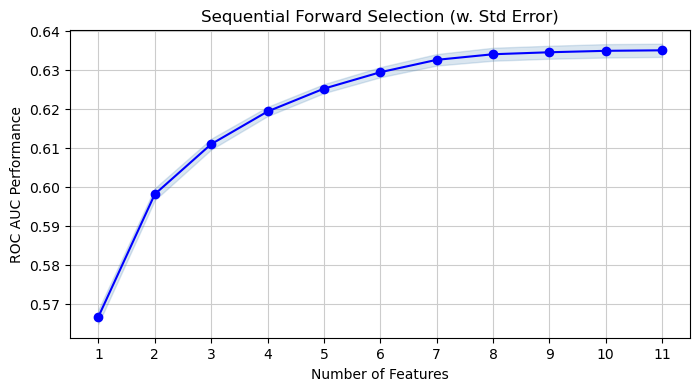

In [36]:
# sfs_parsi_cv5.subsets_
plot_sfs(sfs_parsi_cv5.get_metric_dict(), kind='std_err', ylabel= 'ROC AUC Performance')
plt.title("Sequential Forward Selection (w. Std Error)")
plt.show()

In [37]:
## Get the features included in the most parsimonious model
inc_WOE_features = list(sfs_parsi_cv5.k_feature_names_)
inc_vars = [inc_WOE_var.split('WOE_')[1] for inc_WOE_var in inc_WOE_features]
inc_WOE_features

['WOE_ltv',
 'WOE_disbursed_amount',
 'WOE_PERF_CNS_SC_DESC',
 'WOE_State_ID',
 'WOE_DaysSinceDisbursement',
 'WOE_PRI_SANCTIONED_AMOUNT',
 'WOE_PRIMARY_INSTAL_AMT',
 'WOE_AgeInMonths',
 'WOE_manufacturer_id']

In [38]:
print("***** Model results: {} Variables *****".format(len(inc_WOE_features)))
## Use the stepwise selected variable and get coefficients by fitting just the training set
## For this demo, this will be our final model.
WOELR_clf.fit(trn_woe_dat.loc[:, inc_WOE_features], trn_woe_dat.loc[:, targ_var])
coef_df = pd.DataFrame({'Coef': np.concatenate([WOELR_clf.intercept_, WOELR_clf.coef_.ravel()])}
                       , index=['Intercept']+inc_vars)
coef_df.index.name = 'var_name'
display(coef_df)

***** Model results: 9 Variables *****


,Coef
var_name,
Intercept,-1.226398
ltv,0.943314
disbursed_amount,0.463756
PERF_CNS_SC_DESC,0.929765
State_ID,0.934111
DaysSinceDisbursement,0.958830
PRI_SANCTIONED_AMOUNT,0.875350
PRIMARY_INSTAL_AMT,0.427175
AgeInMonths,0.772307


In [39]:
trn_preds = WOELR_clf.predict_proba(woe_dat.loc[~woe_dat.val001, inc_WOE_features])[:,1]
print( "Training AUC =", metrics.roc_auc_score(woe_dat.loc[~woe_dat.val001, targ_var], trn_preds) )
print( ks_2samp(trn_preds[woe_dat.loc[~woe_dat.val001, targ_var]==1]
                , trn_preds[woe_dat.loc[~woe_dat.val001, targ_var]==0]), "\n" )

val_preds = WOELR_clf.predict_proba(woe_dat.loc[woe_dat.val001, inc_WOE_features])[:,1]
print( "Validation AUC =", metrics.roc_auc_score(woe_dat.loc[woe_dat.val001, targ_var], val_preds) )
print( ks_2samp(val_preds[woe_dat.loc[woe_dat.val001, targ_var]==1]
                , val_preds[woe_dat.loc[woe_dat.val001, targ_var]==0]) )

Training AUC = 0.6363784015579493
KstestResult(statistic=0.19851608937343945, pvalue=0.0) 

Validation AUC = 0.6328219772158576
KstestResult(statistic=0.1915540516142193, pvalue=0.0)


In [40]:
## Get the model intercept out as base score
base_score = coef_df.iloc[0][0]
base_score

-1.226397712916087

## Output final model as a scorecard

In [41]:
## Create a scorecard
scorecard = pd.merge( scorecards_df.loc[inc_vars,:].iloc[:,:(scorecards_df.columns.get_loc('WOE')+1)]
                        , coef_df.iloc[1:], left_index=True, right_index=True)
scorecard['Score'] = scorecard.WOE * scorecard.Coef

scorecard.reset_index(['req_cuts'], drop=True, inplace=True)
scorecard.drop(columns=['ranks', 'Y0', 'p_XgY1', 'p_XgY0'], inplace=True)

## Attach the base score as meta-data
scorecard.base_score = base_score
scorecard = add_scorecard_points(scorecard, PDO=50, standardSc_pts=500, standardSc_odds=19
                                 , pts_dec_prec=0, trndict=trndict)

scorecard.head(51)

bin  \
var_name              binner  bins bin_idx                                                      
Intercept             NaN     0    -1                                                    None   
ltv                   entropy 6     0                                                       .   
                                    1                                         [10.03, 57.995)   
                                    2                                        [57.995, 66.815)   
                                    3                                        [66.815, 72.725)   
                                    4                                        [72.725, 79.295)   
                                    5                                           [79.295, inf)   
disbursed_amount      gini    9     0                                                       .   
                                    1                                      [13664.0, 40109.5)   
                                    2                                      [40109.5, 44714.0)   
                                    3                                      [44714.0, 47392.0)   
                                    4                                      [47392.0, 51911.0)   
                                    5                                      [51911.0, 55395.5)   
                                    6                                      [55395.5, 66723.5)   
                                    7                                      [66723.5, 84704.5)   
                                    8                                          [84704.5, inf)   
PERF_CNS_SC_DESC      none    19    0                                                       .   
                                    1                                         C-Very Low Risk   
                                    2                                         A-Very Low Risk   
                                    3                                         D-Very Low Risk   
                                    4                                         B-Very Low Risk   
                                    5                                        M-Very High Risk   
                                    6                                              F-Low Risk   
                                    7                                             K-High Risk   
                                    8                                           H-Medium Risk   
                                    9                                              E-Low Risk   
                                    10                                          I-Medium Risk   
                                    11                                             G-Low Risk   
                                    12           Not Scored: Sufficient History Not Available   
                                    13      Not Scored: Not Enough Info available on the c...   
                                    14                                            J-High Risk   
                                    15      Not Scored: No Activity seen on the customer (...   
                                    16      Not Scored: No Updates available in last 36 mo...   
                                    17                                       L-Very High Risk   
                                    18                                                  Other   
State_ID              entropy 9     0                                                       .   
                                    1                                                       4   
                                    2                                                       3   
                                    3                                                      13   
                                    4                                                       8   
                

,,,bins,IV,nIV,KLY1Y0,KLY0Y1,monotonic,monotonicity
var_name,binner,req_cuts,,,,,,,
AgeInMonths,entropy,6,7,0.010227,0.005255,0.005129,0.005097,True,-1
DaysSinceDisbursement,entropy,6,7,0.023125,0.011884,0.011783,0.011341,False,0
PERF_CNS_SC_DESC,none,0,19,0.056214,0.019092,0.027062,0.029153,None,0
PRIMARY_INSTAL_AMT,gini,6,7,0.012444,0.006395,-0.038689,0.051133,False,0
PRI_SANCTIONED_AMOUNT,entropy,8,9,0.023071,0.010500,-0.033969,0.057041,False,0
State_ID,entropy,8,9,0.034110,0.015524,0.017842,0.016268,None,0
disbursed_amount,gini,8,9,0.060745,0.027646,0.029329,0.031416,False,0
ltv,entropy,5,6,0.068366,0.038156,0.032820,0.035547,True,1
manufacturer_id,entropy,6,7,0.010152,0.005217,0.005228,0.004924,None,0


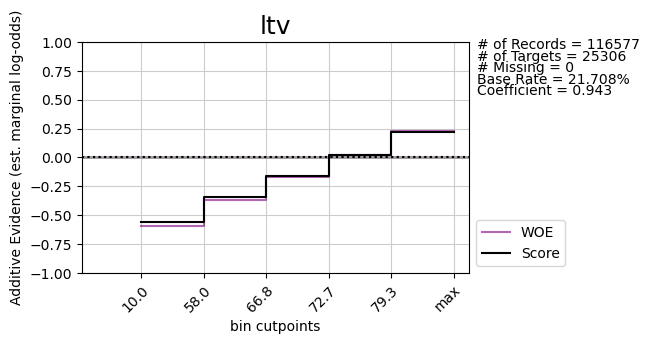

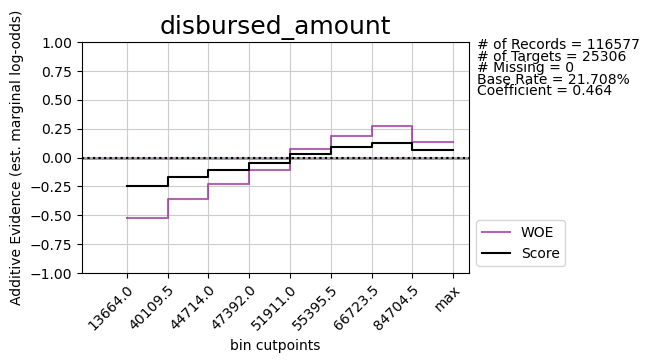

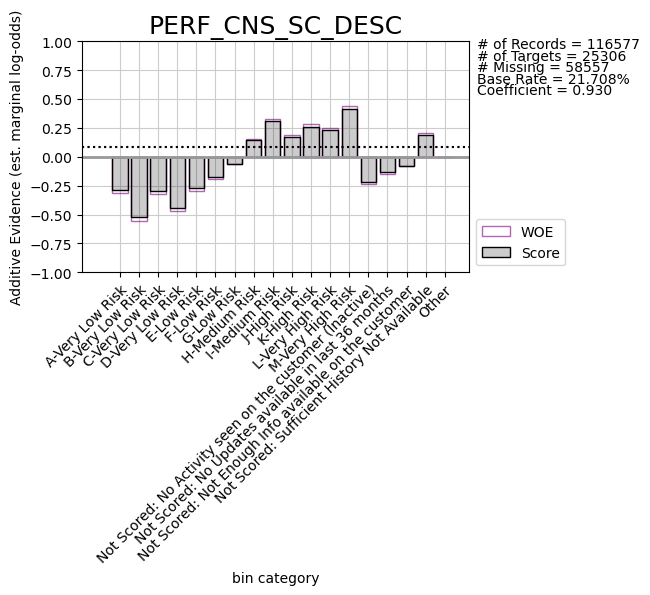

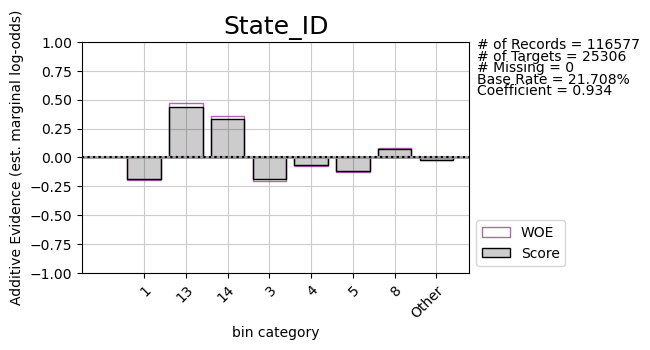

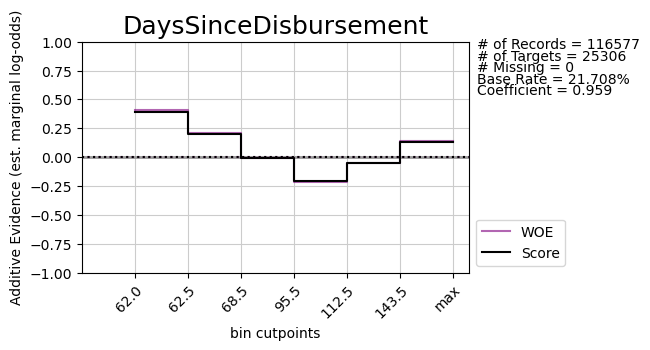

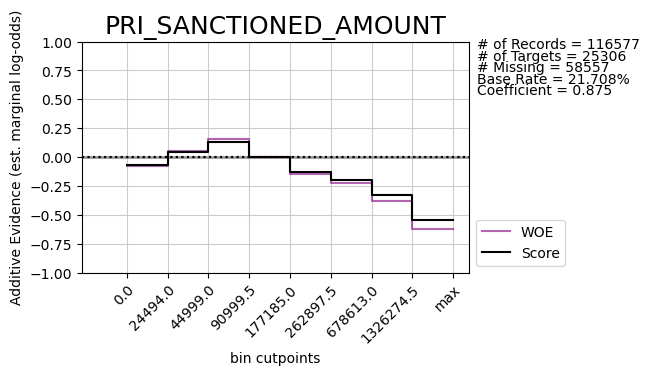

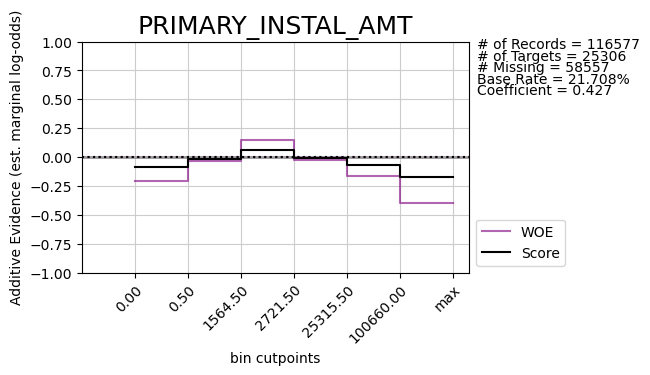

In [42]:
display(gen_uscm_df(scorecards_df.loc[inc_vars,:]))

## Plot the marginal effects for the scorecard above
sc_vars = scorecard[1:].index.get_level_values('var_name').unique()
for p_var in sc_vars[:-2]:
    woesc_plot(scorecard.loc[[p_var],:], sort_values=True) # , sort_values=True, orig_scale=True)